In [51]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from protest_impact.data.protests import get_climate_protests

protests = get_climate_protests(groups=["fff", "alg", "xr", "eg"], all_columns=True)

In [56]:
from protest_impact.instrumental_variables import (
    instrumental_variables,
    size_labels,
    size_pairs,
)

space = dict(
    endog=[["log10(size)"]],  # , ["log(log(size))"]
    instr=["weather_and_covid"],
    use_exog=[True],
    discourse=["climate_and_protest", "climate_not_protest", "climate"],
    n_days=[1],
    random_discourse=[False],
    method=["OLS", "Manual_2SLS", "AutoRFRF"],  # "RFLR", "RFRF",
)

results = instrumental_variables(protests, space)

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


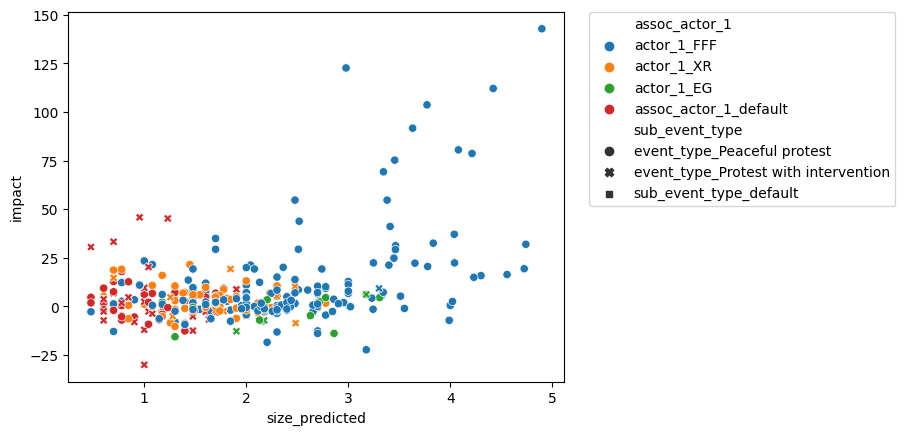

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


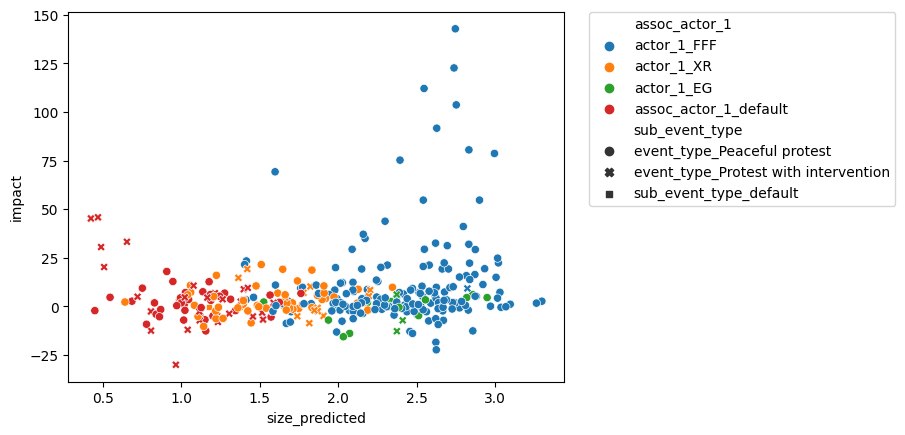

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


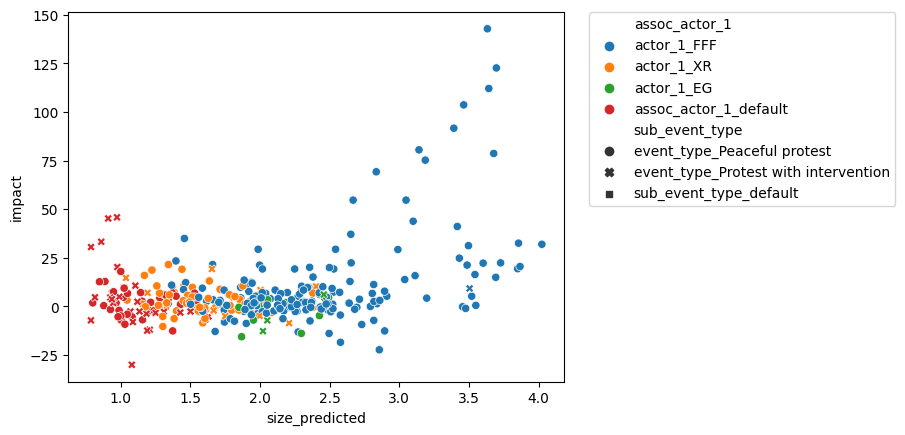

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


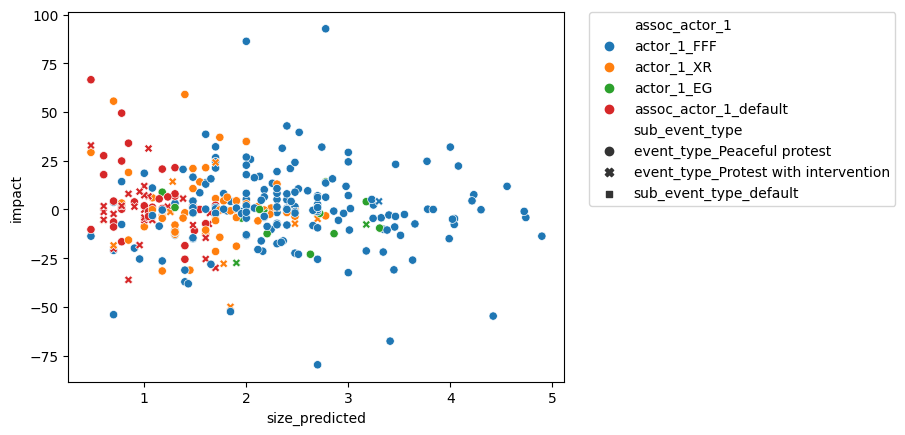

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


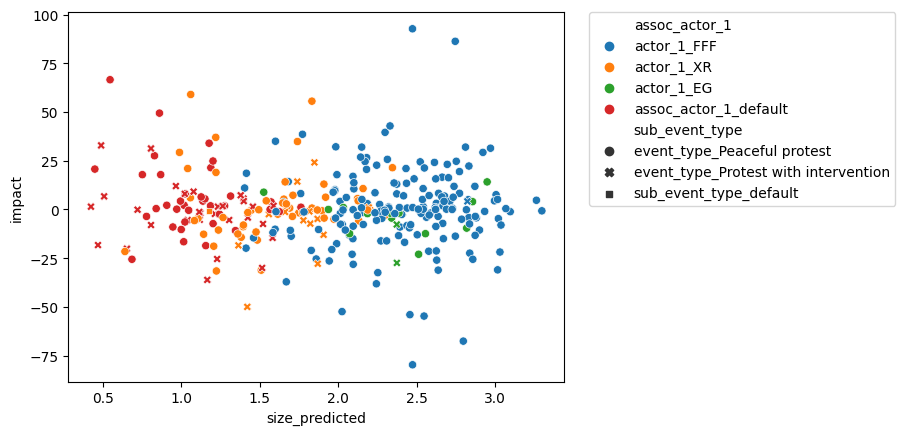

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


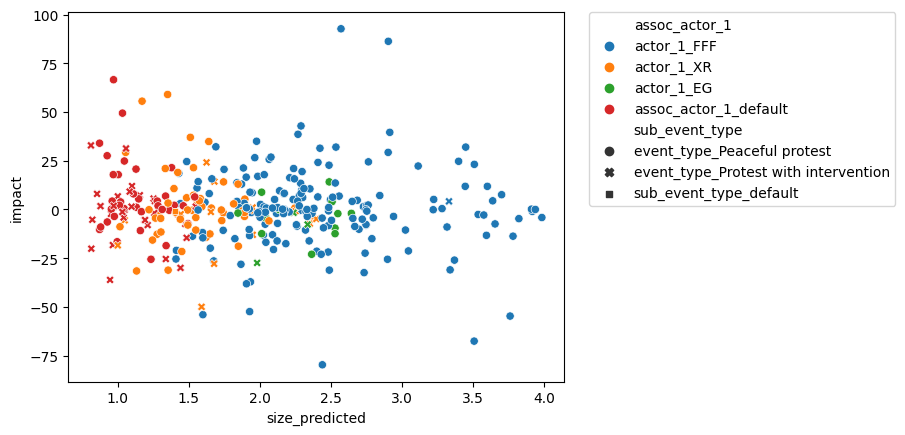

climate ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


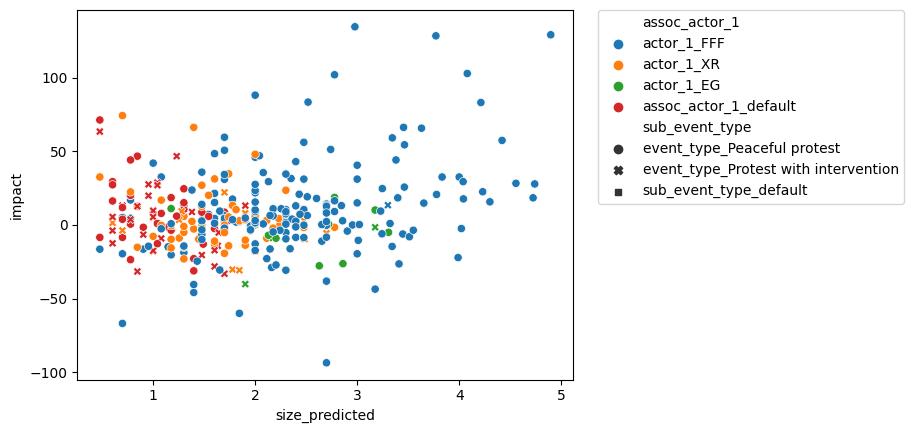

climate ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


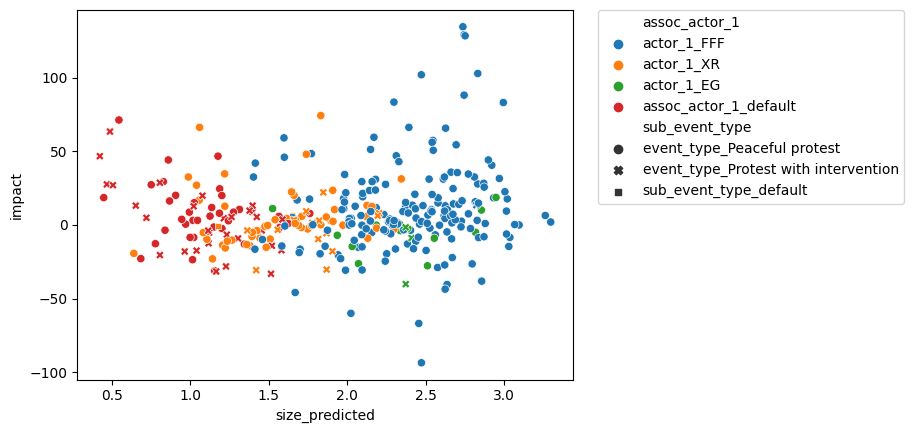

climate ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


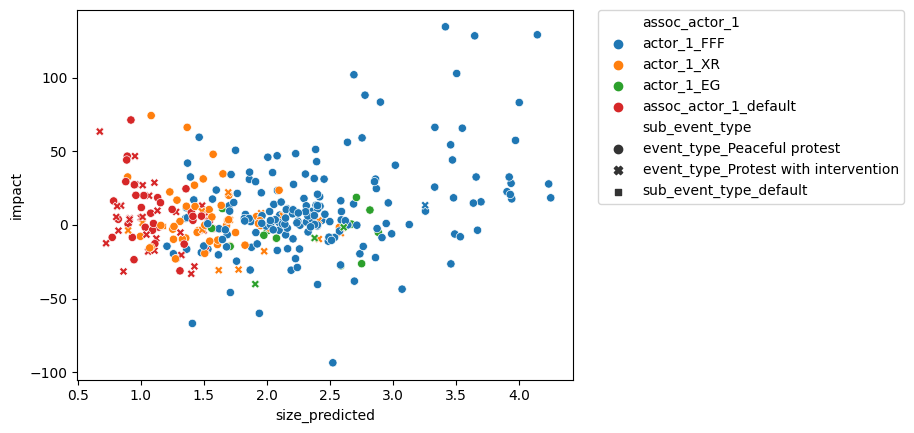

In [58]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def undummify(df, prefix, default=None):
    dummy_columns = [col for col in df.columns if col.startswith(prefix)]
    default = default or prefix + "_default"
    undummified = pd.from_dummies(df[dummy_columns], default_category=default, sep="_")
    undummified.columns = [prefix]
    df_new = pd.concat([df.drop(dummy_columns, axis=1), undummified], axis=1)
    return df_new


def get_df(result):
    df = pd.DataFrame(res.second_stage.X)
    df["impact"] = res.second_stage.y
    df["impact_predicted"] = res.second_stage.y_hat
    for c in ["assoc_actor_1", "admin1", "sub_event_type", "actor2", "weekday"]:
        df = undummify(df, c)
    return df


mpl.rc("font", family="sans-serif")

for name, res in results.items():
    print(name.replace("\n", " "))
    # try:
    #     plt.scatter(res.first_stage.y, res.first_stage.y_hat, s=4)
    #     plt.show()
    # except:
    #     pass
    # plt.scatter(res.second_stage.X["size_predicted"], res.second_stage.y, s=4)
    # plt.xlabel("size_predicted")
    # plt.ylabel("impact")
    # plt.axhline(0, color="black")
    # plt.scatter(res.second_stage.X["size_predicted"], res.second_stage.y_hat, s=4)
    # plt.xlabel("size_predicted")
    # plt.ylabel("impact_predicted")
    # plt.axhline(0, color="black")
    df = get_df(res)
    sns.scatterplot(
        data=df,
        x="size_predicted",
        y="impact",
        hue="assoc_actor_1",
        style="sub_event_type",
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


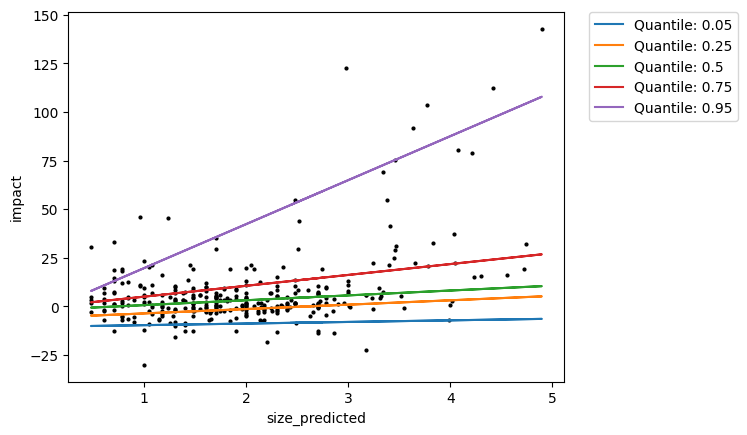

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


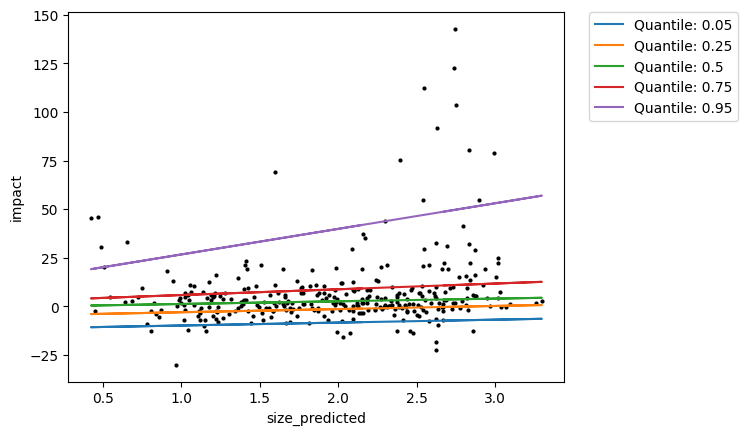

climate_and_protest ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


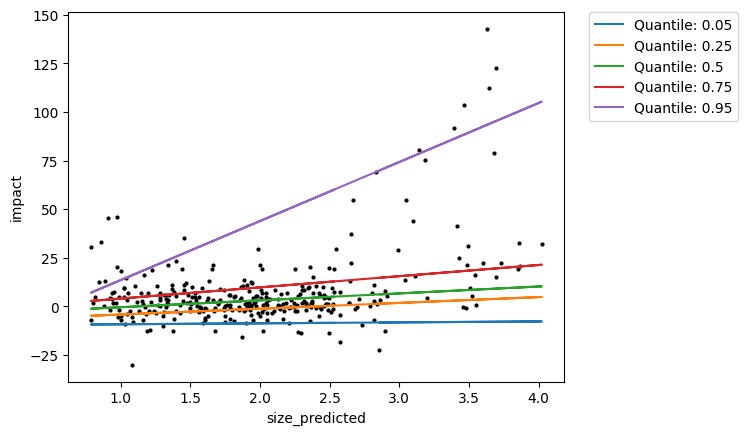

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


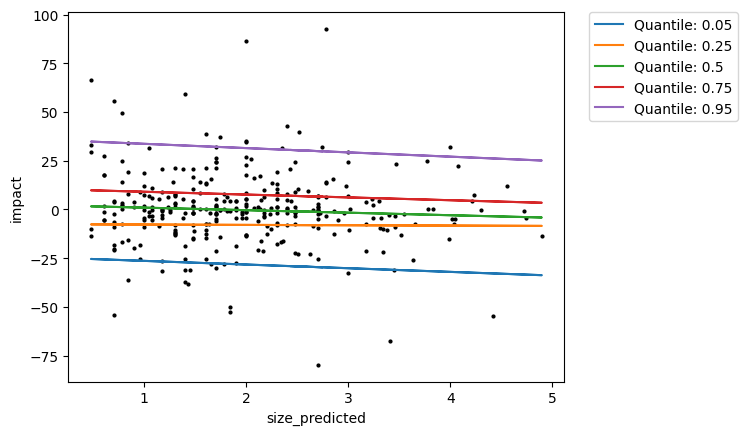

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


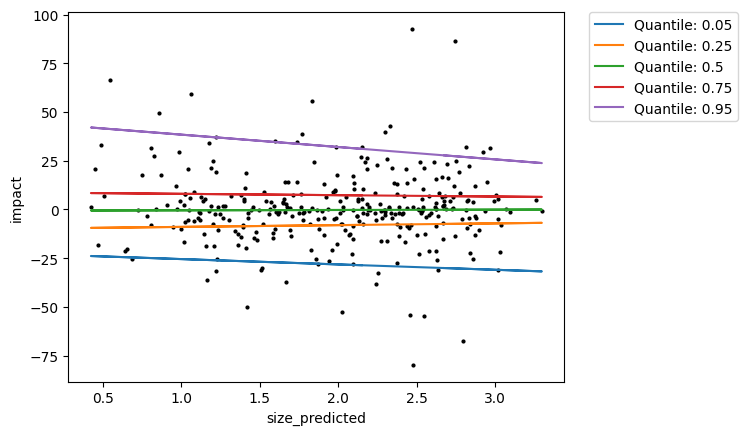

climate_not_protest ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


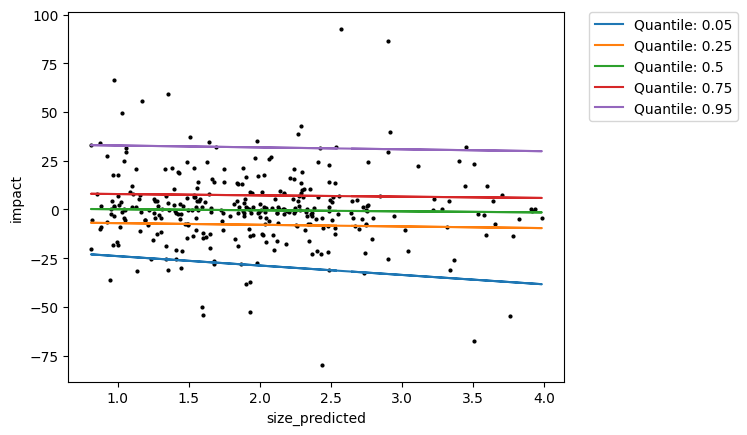

climate ['log10(size)'] ~ weather_and_covid with exog 1 days OLS


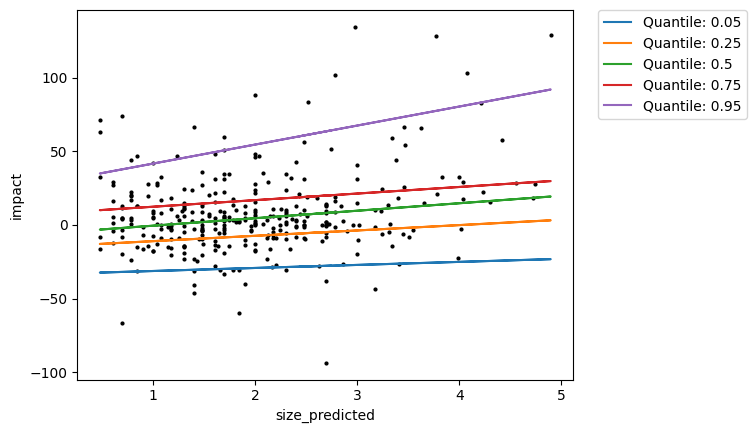

climate ['log10(size)'] ~ weather_and_covid with exog 1 days Manual_2SLS


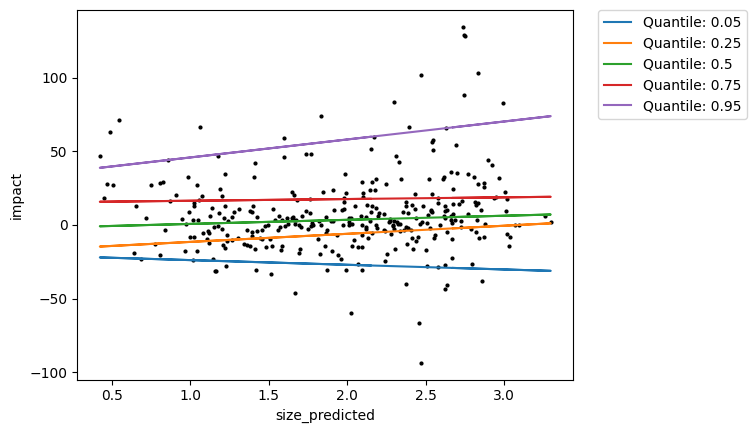

climate ['log10(size)'] ~ weather_and_covid with exog 1 days AutoRFRF


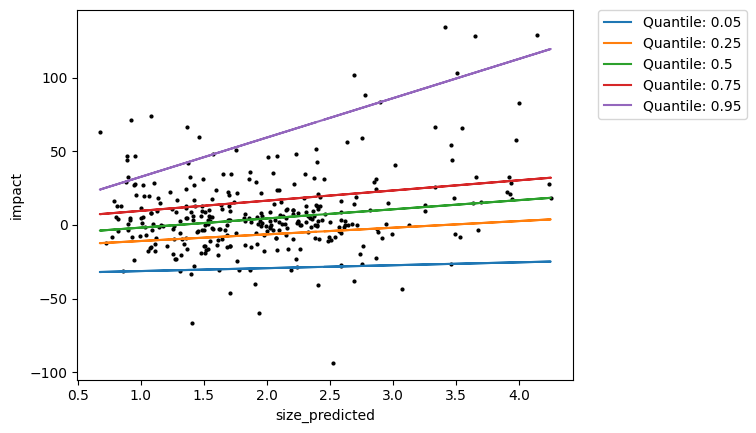

In [72]:
import numpy as np
from sklearn.linear_model import QuantileRegressor

for name, res in list(results.items()):
    print(name.replace("\n", " "))
    df = get_df(res)
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    # X = df.drop(["impact", "impact_predicted"], axis=1).values # TODO
    X = df["size_predicted"].values.reshape(-1, 1)
    y = df["impact"].values.reshape(-1, 1)

    # from the sklearn docs
    predictions = {}
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred
    plt.scatter(X, y, s=4, color="black")
    for quantile, y_pred in predictions.items():
        plt.plot(X, y_pred, label=f"Quantile: {quantile}")
    plt.xlabel("size_predicted")
    plt.ylabel("impact")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()